In [1]:
import os
import time
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset folder
dataset_path = 'dataset_ebs_timm'  # Update this path

In [3]:
# Preset values
dropout_rate = 0.0
batch_size = 32
learning_rate = 1e-4
num_epochs = 10
image_size = 224

In [4]:
# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load custom dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

In [5]:
# Split dataset into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
# Load pre-trained ViT model with specified dropout rate
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes, drop_rate=dropout_rate)
model = model.to(device)

In [8]:
# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Summary info before training loop
print(f"Custom dataset folder: {dataset_path}")
print(f"Number of classes: {num_classes} with class names: {class_names}")
print(f"Preset dropout rate: {dropout_rate}")
print(f"Training/Testing Ratio: {train_size}/{val_size}")
print(f"Learning rate: {learning_rate}")

Custom dataset folder: dataset_ebs_timm
Number of classes: 2 with class names: ['goods', 'rejects']
Preset dropout rate: 0.0
Training/Testing Ratio: 491/211
Learning rate: 0.0001


In [10]:
# Training and validation
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

In [11]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)
    
    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)
    
    # Calculate average losses and accuracy
    train_loss = train_loss / train_size
    train_acc = train_correct.double() / train_size
    val_loss = val_loss / val_size
    val_acc = val_correct.double() / val_size

    # Save history for plotting
    train_acc_history.append(train_acc.cpu().numpy())
    train_loss_history.append(train_loss)
    val_acc_history.append(val_acc.cpu().numpy())
    val_loss_history.append(val_loss)

    # Print results every epoch
    print(f"Epoch {epoch+1}/{num_epochs}.. "
          f"Train loss: {train_loss:.4f}.. "
          f"Train accuracy: {train_acc:.4f}.. "
          f"Val loss: {val_loss:.4f}.. "
          f"Val accuracy: {val_acc:.4f}")

Epoch 1/10.. Train loss: 0.8061.. Train accuracy: 0.6497.. Val loss: 0.6705.. Val accuracy: 0.6730
Epoch 2/10.. Train loss: 0.5365.. Train accuracy: 0.7515.. Val loss: 0.3196.. Val accuracy: 0.8768
Epoch 3/10.. Train loss: 0.5097.. Train accuracy: 0.8024.. Val loss: 0.8137.. Val accuracy: 0.3507
Epoch 4/10.. Train loss: 0.5160.. Train accuracy: 0.7495.. Val loss: 0.2246.. Val accuracy: 0.9194
Epoch 5/10.. Train loss: 0.0866.. Train accuracy: 0.9796.. Val loss: 0.1482.. Val accuracy: 0.9716
Epoch 6/10.. Train loss: 0.0813.. Train accuracy: 0.9776.. Val loss: 0.0246.. Val accuracy: 0.9953
Epoch 7/10.. Train loss: 0.0149.. Train accuracy: 0.9939.. Val loss: 0.0017.. Val accuracy: 1.0000
Epoch 8/10.. Train loss: 0.0060.. Train accuracy: 0.9980.. Val loss: 0.0054.. Val accuracy: 1.0000
Epoch 9/10.. Train loss: 0.0003.. Train accuracy: 1.0000.. Val loss: 0.0003.. Val accuracy: 1.0000
Epoch 10/10.. Train loss: 0.0002.. Train accuracy: 1.0000.. Val loss: 0.0004.. Val accuracy: 1.0000


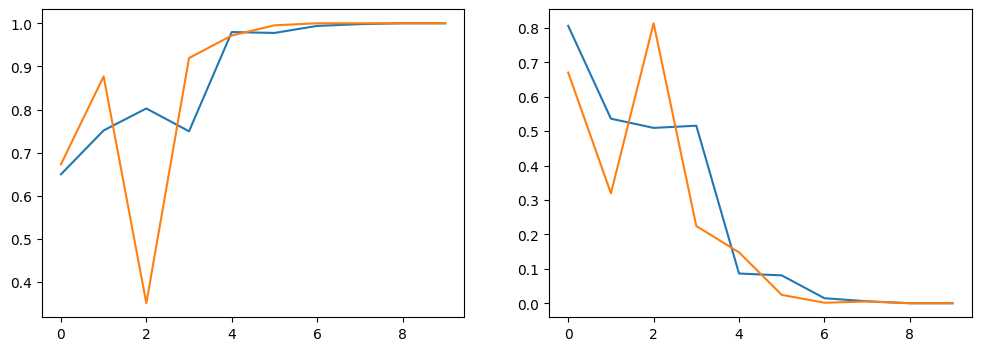

In [18]:
# Plot trend chart for Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')

In [12]:
# Save the model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_save_path = os.path.join(dataset_path, f'model_{timestamp}.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to dataset_ebs_timm\model_20231220_105848.pth
